<a href="https://colab.research.google.com/github/MrBigBrane/Machine-Learning/blob/main/CNN_Psychometric_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

# draw lines
from skimage.draw import line_aa

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [70]:
nGauss  = 1000
imgSize = 30

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize two tensor containing images
imagesOcc   = torch.zeros(nGauss,1,imgSize,imgSize)
labels = torch.zeros(nGauss, 1)
classes = ['horizontal','vertical']

for i in range(nGauss):

  # create the gaussian with random centers
  # ro = 1.5*np.random.randn(2) # ro = random offset
  # G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # # and add noise
  # G  = G + np.random.randn(imgSize,imgSize)/5
  G  = np.random.randn(imgSize,imgSize)/5

  # add a random bar randomly
  i1 = np.random.choice(np.arange(10,imgSize-10))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1 # horizontal bar
    labels[i, :] = 0
  else:
    G[:,i1:i1+i2] = 1 #vertical bar
    labels[i, :] = 1

  # add to the tensor with occlusion
  imagesOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

In [71]:
print(labels[2])
print(classes[int(labels[2])])

tensor([0.])
horizontal


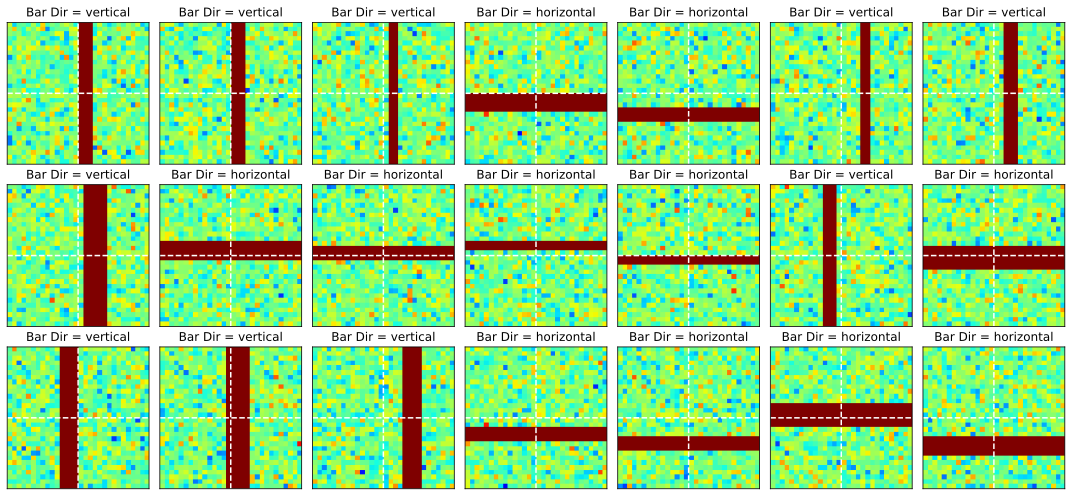

In [72]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( imagesOcc[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='upper')
  ax.set_title(f'Bar Dir = {classes[int(labels[whichpic])]}')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [73]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(imagesOcc, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [74]:
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([900, 1, 30, 30])
torch.Size([900, 1])


In [75]:
# create a class for the model
def makeTheNet():

  class barnet(nn.Module):
    def __init__(self):
      super().__init__()

      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(

          # conv/pool block 1
          nn.Conv2d(1,6,3,padding=1),  # output size: (30+2*1-3)/1 + 1 = 30
          nn.ReLU(),                   #
          nn.AvgPool2d(2,2),           # output size: 30/2 = 15

          # conv/pool block 2
          nn.Conv2d(6,4,3,padding=1),  # output size: (15+2*1-3)/1 + 1 = 15
          nn.ReLU(),                   #
          nn.AvgPool2d(2,2),           # output size: 15/2 = 7

          # linear decision layer
          nn.Flatten(),                # vectorize conv2 block output
          nn.Linear(7*7*4,50),         # output size: 50
          nn.Linear(50,1),             # output size: 3
      )

    def forward(self,x):
      return self.enc(x)

  # create the model instance
  net = barnet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [76]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(yHat)
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

tensor([[-0.0387],
        [-0.0403],
        [-0.0498],
        [-0.0451],
        [-0.0393],
        [-0.0407],
        [-0.0352],
        [-0.0371],
        [-0.0458],
        [-0.0560],
        [-0.0395],
        [-0.0329],
        [-0.0383],
        [-0.0430],
        [-0.0334],
        [-0.0420]], grad_fn=<AddmmBackward0>)
 
torch.Size([16, 1])
 
Loss:
tensor(0.6875, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [77]:
def function2trainTheModel():

  # number of epochs
  numepochs = 30

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # accuracy from this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # and accuracy across the batches
    trainAcc[epochi]  = np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # extract the loss for this test epoch
    testLoss[epochi] = loss.item()
    # extract the accuracy for this test epoch
    testAcc[epochi]  = 100*torch.mean(((yHat>0) == y).float()).item()


  # end epochs

  # function output
  return trainLoss,trainAcc,testLoss,testAcc,net

In [78]:
trainLoss,trainAcc,testLoss,testAcc,net = function2trainTheModel()

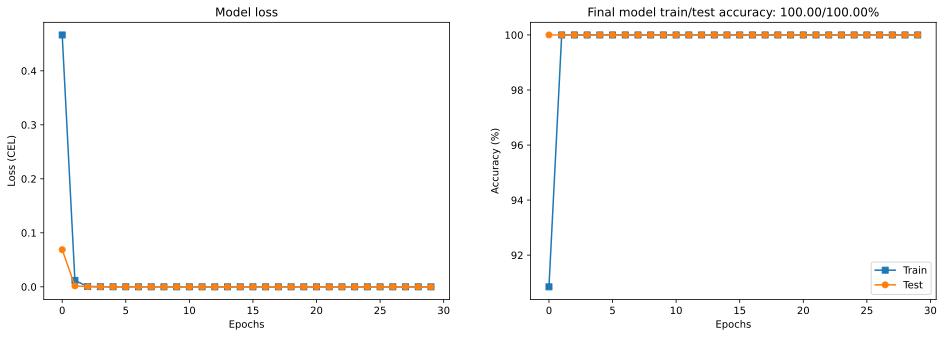

In [79]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
# ax[0].plot(len(testLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
# ax[1].plot(len(test)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

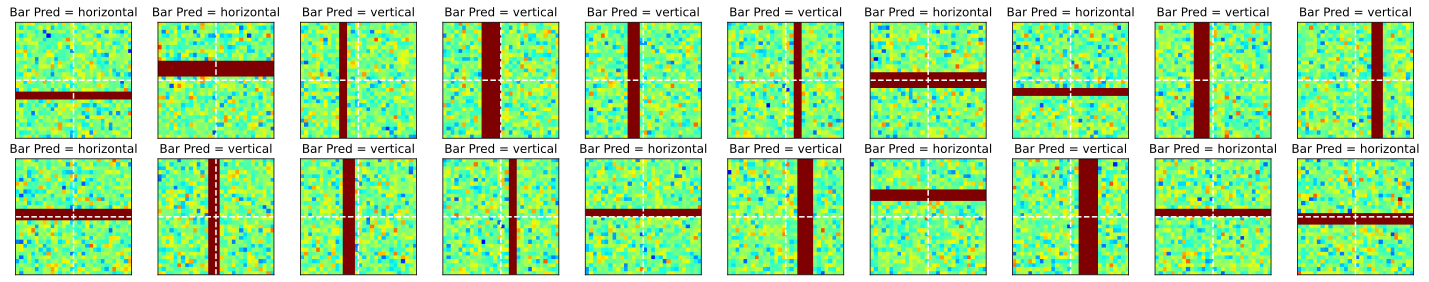

In [80]:
# visualize some images

X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(20,4))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(X.shape[0])
  # get the Gaussian and draw it, and draw the white guide-lines
  G = torch.squeeze( X[whichpic,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
  ax.set_title(f'Bar Pred = {classes[int(y[whichpic])]}')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')

  # some final plotting niceties
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlim([-4,4])
  ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()

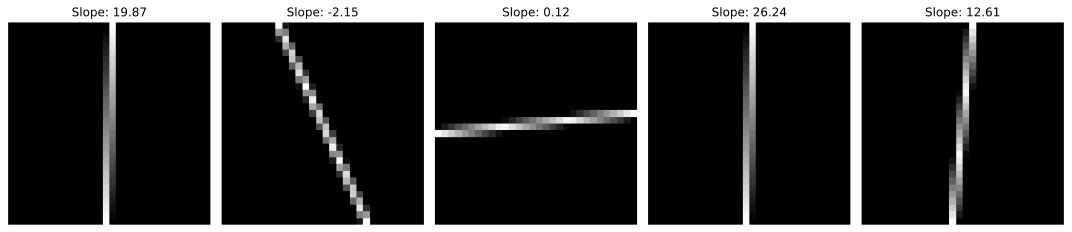

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line_aa

# Parameters
num_images = 1000      # Number of images
height, width = 30, 30  # Dimensions of each image

# Center point of the image
center_x, center_y = height // 2, width // 2

# Function to calculate endpoints so the line passes through the center and fully crosses the image
def calculate_line_endpoints(center_x, center_y, height, width, slope):
    if slope == 0:
        return (center_x, 0), (center_x, width - 1)
    elif slope >= -1 and slope <=1:
        x1 = 0
        y1 = int(center_y + center_x * slope)
        x2 = height - 1
        y2 = int(center_y - (height - 1 - center_x) * slope)
        return (x1, y1), (x2, y2)
    elif slope > 1 or slope < -1:
        y1 = 0
        x1 = int(center_x + center_y / slope)
        y2 = width - 1
        x2 = int(center_x - (width - 1 - center_y) / slope)
        return (x1, y1), (x2, y2)

# Generate images with lines passing through the center and crossing the image
images = []
slopes = []

for i in range(num_images):
    # Create a blank image
    image = np.zeros((height, width), dtype=np.float32)

    # Generate a random slope
    slope = (np.random.uniform(-30, 30))

    # Calculate endpoints of the line
    (x1, y1), (x2, y2) = calculate_line_endpoints(center_x, center_y, height, width, slope)

    # Generate the line passing through the calculated endpoints
    rr, cc, val = line_aa(y1, x1, y2, x2)

    # Draw the line on the image
    image[rr, cc] += val

    # Append the image to the list
    images.append(image)
    slopes.append(slope)

# Plot all the generated images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Slope: {slopes[i]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [103]:
linesFeed = torch.tensor(np.array(images)).view(len(images), 1, 30, 30)
lines = np.array(images)
slopes = np.array(slopes).reshape(-1,1)

In [104]:
pred = net(linesFeed)
# predClass = classes[int(pred > 0)]
predLabels = (pred > 0).int()
trueLabels1 = (slopes > 1).astype(int)
trueLabels2 = (slopes < -1).astype(int)
trueLabels = trueLabels1 + trueLabels2

incorrectIndices = (predLabels.numpy() != trueLabels).squeeze()
incorrectLines = lines[incorrectIndices,:,:]
incorrectLabels = trueLabels[incorrectIndices]
incorrectPred = predLabels[incorrectIndices]
incorrectSlopes = slopes[incorrectIndices]

incorrectLines.shape

(3, 30, 30)

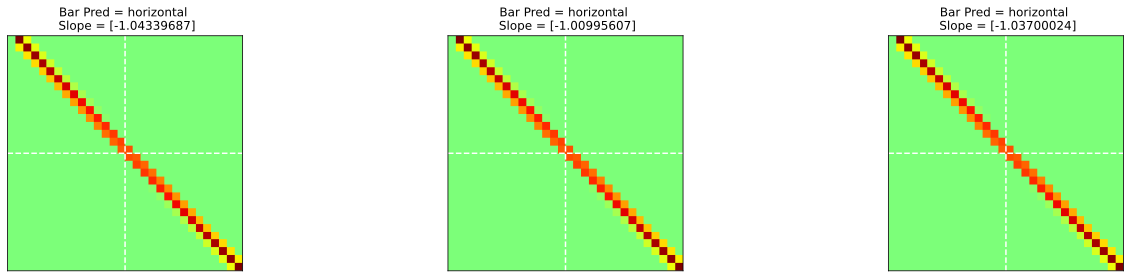

In [100]:
fig,axs = plt.subplots(1,incorrectPred.shape[0],figsize=(20,4))

if(incorrectLines.shape[0]>0):
  for i,ax in enumerate(axs.flatten()):
    # whichpic = np.random.randint(incorrectLines.shape[0])
    # get the Gaussian and draw it, and draw the white guide-lines
    line = np.squeeze( incorrectLines[i,:,:] )
    ax.imshow(line,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
    ax.set_title(f'Bar Pred = {classes[incorrectPred[i]]} \n Slope = {-incorrectSlopes[i]}')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')

    # some final plotting niceties
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])

  plt.tight_layout()
  plt.show()

In [ ]:
for i in range(len(slopes)):
  if pred[i]>0:
    plt.plot([slopes[i],slopes[i]],[F.sigmoid(pred[i]).detach().item(), 1],'r')
  else:
    plt.plot([slopes[i],slopes[i]],[F.sigmoid(pred[i]).detach().item(), 0],'g')

plt.plot(slopes, F.sigmoid(pred).detach().numpy(),'ko',label='Train')
plt.xlabel('Slope')
plt.ylabel('Probability (vertical)')
plt.title('Model loss')
plt.xlim([-10,10])
# plt.ylim([-10, 10])
plt.ylim([0, 1])
plt.show()